# Training Neural Networks
In this exercise, you will train a neural network using PyTorch. You will be provided some starter code and will fill in the blanks. 

This will walk through the entire process, from loading datasets to creating transforms, all the way through to creating the network code and training it to classify the CIFAR-10 dataset.

In [1]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Loading and Preprocessing Data
In this section, we will load and preprocess our data using any relevant methods from `transforms` and `datasets`.
Then, we will create `DataLoader`s for our train and test sets.

If you have trouble, feel free to consult the documentation for [transforms](https://pytorch.org/vision/0.12/transforms.html) and [CIFAR-10](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html#torchvision.datasets.CIFAR10)

In [3]:
# Establish our transform
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load train and test datasets
training_data = datasets.CIFAR10(root="data", train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root="data", train=False, download=True, transform=transform)

# Create the training and test dataloaders with a batch size of 32
train_loader = DataLoader(training_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

Files already downloaded and verified
Files already downloaded and verified


## Defining our Neural Network
Once our data is loaded, we want to define our model. 
For this example, we want to use a fully-connected model, which means we will need to use the `flatten` method to take our 32 x 32 x 3 tensor and flatten it into a single input. 

We want to have at least 3 fully connected layers. 
The input size of the first layer will need to account for the flattening and will be 32 * 32 * 3.
Feel free to experiment here, and if you need additional help, consult the [PyTorch documentation](https://pytorch.org/docs/stable/nn.html)

In [4]:
# Define the class for your neural network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.fc1 = nn.Linear(32 * 32 * 3, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the model
net = Net()
net.to(device)

Net(
  (fc1): Linear(in_features=3072, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## Optimizer and Loss function
Before we get into our training loop, we need to choose an optimizer and loss function for our network. 

In [5]:
# Choose an optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Choose a loss function
criterion = nn.CrossEntropyLoss()

## Creating the Training Loop
With our network, optimizer, and loss function, we can now begin the training step! 
Using the test set to validate our accuracy, we can see when our network has given us the best fit.

In [6]:
num_epochs = 10

# Establish a list for our history
train_loss_history = list()
val_loss_history = list()

for epoch in range(num_epochs):
    net.train()
    train_loss = 0.0
    train_correct = 0
    for i, data in enumerate(train_loader):
        # data is a list of [inputs, labels]
        inputs, labels = data

        # Pass to GPU if available.
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).float().mean().item()
        train_loss += loss.item()
    print(f'Epoch {epoch + 1} training accuracy: {train_correct/len(train_loader)*100:.2f}% training loss: {train_loss/len(train_loader):.5f}')
    train_loss_history.append(train_loss/len(train_loader))


    val_loss = 0.0
    val_correct = 0
    net.eval()
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)
        val_correct += (preds == labels).float().mean().item()
        val_loss += loss.item()
    print(f'Epoch {epoch + 1} validation accuracy: {val_correct/len(test_loader)*100:.2f}% validation loss: {val_loss/len(test_loader):.5f}')
    val_loss_history.append(val_loss/len(test_loader))

Epoch 1 training accuracy: 41.90% training loss: 1.64068
Epoch 1 validation accuracy: 45.22% validation loss: 1.53843
Epoch 2 training accuracy: 48.52% training loss: 1.45237
Epoch 2 validation accuracy: 48.55% validation loss: 1.44669
Epoch 3 training accuracy: 51.92% training loss: 1.35815
Epoch 3 validation accuracy: 50.34% validation loss: 1.41082
Epoch 4 training accuracy: 54.49% training loss: 1.29113
Epoch 4 validation accuracy: 51.61% validation loss: 1.37957
Epoch 5 training accuracy: 56.28% training loss: 1.23373
Epoch 5 validation accuracy: 50.58% validation loss: 1.41124
Epoch 6 training accuracy: 57.88% training loss: 1.18630
Epoch 6 validation accuracy: 51.45% validation loss: 1.41819
Epoch 7 training accuracy: 59.50% training loss: 1.14179
Epoch 7 validation accuracy: 51.83% validation loss: 1.39958
Epoch 8 training accuracy: 60.84% training loss: 1.10007
Epoch 8 validation accuracy: 51.51% validation loss: 1.42405
Epoch 9 training accuracy: 62.07% training loss: 1.06446

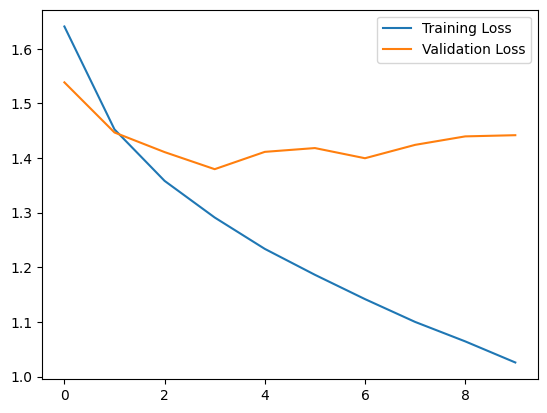

In [7]:
# Plot the training and validation loss history
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()